In [10]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## CC 구하기
- 코호트 테이블 그리기 & 리텐션 정의하기
- 제품 현황(기초체력) 파악하기
  - 이탈률 구하기, 월 별 유입 유저수 구하기
  - cc 계산

### 코호트 테이블 그리기 & 리텐션 정의하기

In [11]:
tb = pd.read_csv('bootcamp_chapter2-1_data.csv')

C:\Users\seongbin\AppData\Local\Temp\ipykernel_20392\4042422027.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  tb = pd.read_csv('bootcamp_chapter2-1_data.csv')


In [12]:
df = tb[tb.transaction_date.notnull()]
df.transaction_date = df.transaction_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

C:\Users\seongbin\AppData\Local\Temp\ipykernel_20392\3523235290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.transaction_date = df.transaction_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [13]:
# 결제 월과 코호트 월 생성
df["transaction_month"] = df["transaction_date"].dt.to_period("M")
df["cohort_month"] = df.groupby("customer_id")["transaction_month"].transform("min")

C:\Users\seongbin\AppData\Local\Temp\ipykernel_20392\4140866780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transaction_month"] = df["transaction_date"].dt.to_period("M")
C:\Users\seongbin\AppData\Local\Temp\ipykernel_20392\4140866780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cohort_month"] = df.groupby("customer_id")["transaction_month"].transform("min")


In [14]:
# 코호트 기간 계산
df["period"] = (df["transaction_month"] - df["cohort_month"]).apply(lambda x: x.n)

C:\Users\seongbin\AppData\Local\Temp\ipykernel_20392\3661698430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["period"] = (df["transaction_month"] - df["cohort_month"]).apply(lambda x: x.n)


In [15]:
# 코호트 테이블 생성
cohort_table = df.groupby(["cohort_month", "period"])["customer_id"].nunique().unstack(fill_value=0)

In [16]:
# 상대적 비율 계산 (최초 월 대비 유지율)
cohort_size = cohort_table.iloc[:, 0]
retention_table = cohort_table.divide(cohort_size, axis=0)

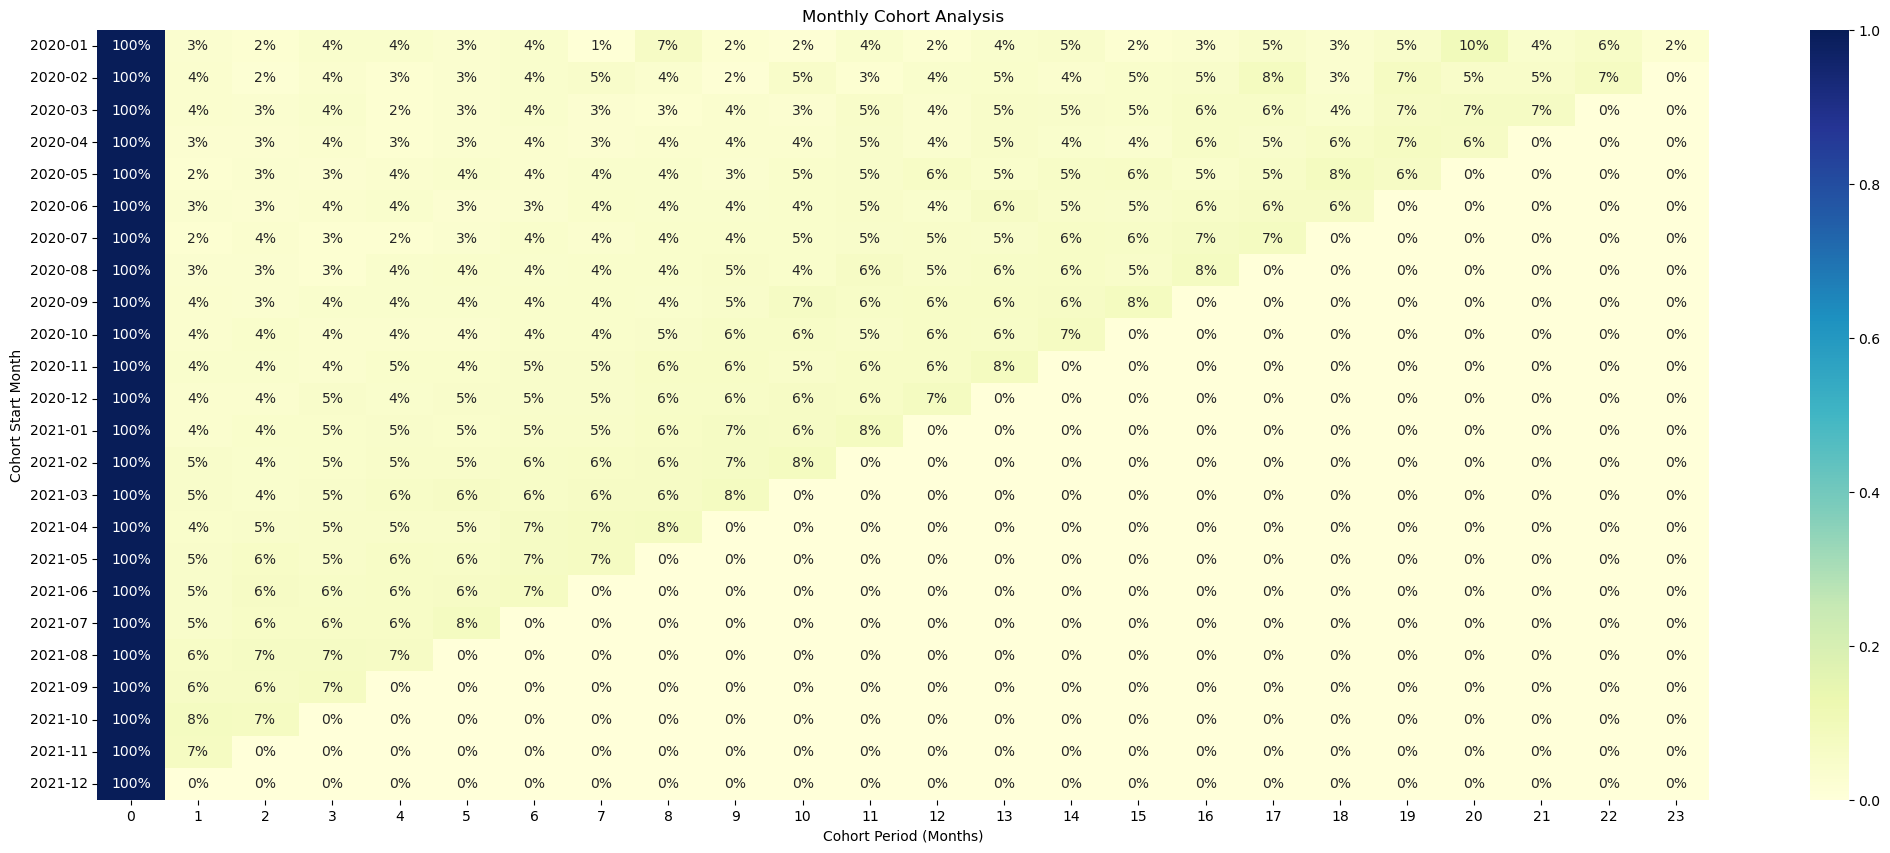

In [17]:
# 시각화
plt.figure(figsize=(26, 10))
sns.heatmap(retention_table, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Monthly Cohort Analysis")
plt.xlabel("Cohort Period (Months)")
plt.ylabel("Cohort Start Month")
plt.show()

### 제품 현황 파악하기

In [463]:
#월평균 획득(Acquisition) 유저 수 구하기
tb['join_date'] = tb['join_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
tb['join_month'] = tb.join_date.dt.to_period('M')
inflow = tb.groupby('join_month').customer_id.nunique().mean()

#Activation, Retention 구하기
activation = tb[tb.transaction_date.notnull()].customer_id.nunique() / tb.customer_id.nunique()
retention = df[df.period==1].customer_id.nunique() / df.customer_id.nunique()

#cc 구하기
cc = inflow / (1-retention)

print('# of users acquire: {}'.format(inflow))
print('activation_rate: {}'.format(activation))
print('retention_rate: {}'.format(retention))
print('cc: {}'.format(cc))

# of users acquire: 9722.305555555555
activation_rate: 0.14286448973294513
retention_rate: 0.04469731816091035
cc: 10177.19905992389


## A/B Test 연습
- T-test
- Chi^2 Test

In [498]:
tb2 = pd.read_csv('bootcamp_chapter2-2_data.csv')

### t-test

In [499]:
from scipy import stats

# 그룹 A와 B의 거래 금액 데이터 추출
group_A_amounts = tb2[tb2['group'] == 'A']['transaction_amount']
group_B_amounts = tb2[tb2['group'] == 'B']['transaction_amount']

# T-검정
t_stat, p_value = stats.ttest_ind(group_A_amounts, group_B_amounts)

# 결과 출력
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 16.245951403745657
P-value: 7.7587830095821455e-53


### Chi^2 Test

In [500]:
# 거래 유무 컬럼 추가 (거래 금액이 0보다 큰 경우를 거래했다고 판단)
tb2['transaction_occurred'] = tb2['transaction_amount'].apply(lambda x: 1 if x > 0 else 0)

# 카이제곱 독립성 검정을 위한 교차표 생성
contingency_table = pd.crosstab(tb2['group'], tb2['transaction_occurred'])

# 카이제곱 검정
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

# 결과 출력
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value_chi2}")
print(f"Degrees of freedom: {dof}")

Chi-squared statistic: 2.3018270752409724
P-value: 0.1292219162956798
Degrees of freedom: 1


In [501]:
# VIP 편입 유무 컬럼 추가 (거래 금액이 100 달러보다 큰 경우를 거래했다고 판단)
tb2['vip_join_yn'] = tb2['transaction_amount'].apply(lambda x: 1 if x > 100 else 0)

# 카이제곱 독립성 검정을 위한 교차표 생성
contingency_table = pd.crosstab(tb2['group'], tb2['vip_join_yn'])

# 카이제곱 검정
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

# 결과 출력
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value_chi2}")
print(f"Degrees of freedom: {dof}")

Chi-squared statistic: 128.16636029411765
P-value: 1.0321829434036975e-29
Degrees of freedom: 1


## 제품 팀과 함께하는 ML
- Shap 모델링
- Visualization & Communication

In [90]:
import shap
import xgboost

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [91]:
df = pd.read_csv('data/ad_data.csv')
df = df.iloc[:, 1:].copy()

In [92]:
train = df.iloc[:, 0:3]
target = df[['sales']]

### 우리의 비즈니스 성과에 설명력이 높은 변수는 무엇일까?

In [85]:
model = xgboost.XGBRFRegressor().fit(train, target)

explainer = shap.Explainer(model)
shap_value = explainer(train)

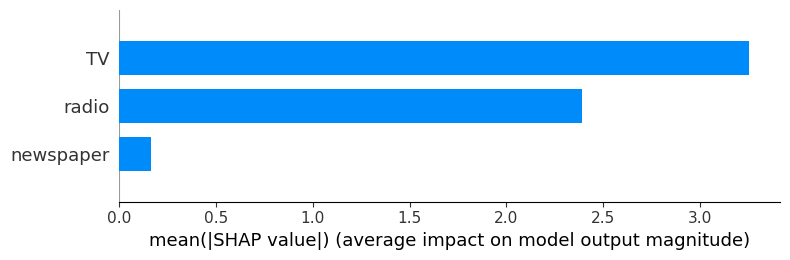

In [86]:
#매체별 절대값 기준 영향도(중요도)
shap.summary_plot(shap_value, train, plot_type='bar')

**TV >> Radio >> Newspaper** 순으로 sales에 대한 영향도가 크네

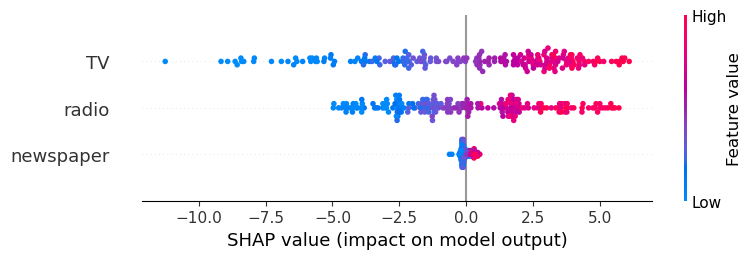

In [47]:
#Summary Plot: 피처 값에 따른 shap value
shap.summary_plot(shap_value, train)

모두 양의 방향으로 영향도를 지니고 있고, 위의 그래프와 동일하게 **TV, Radio**의 영향도가 특히 크네

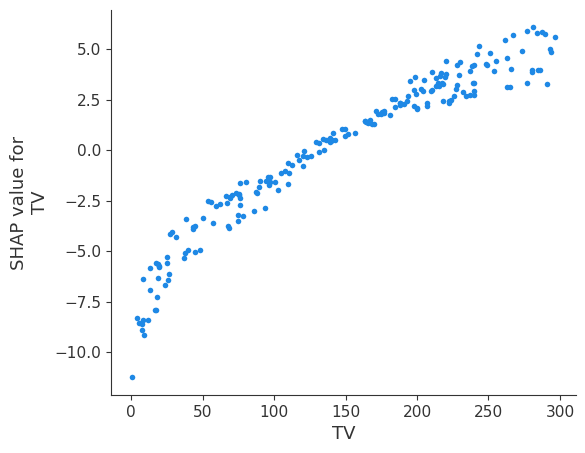

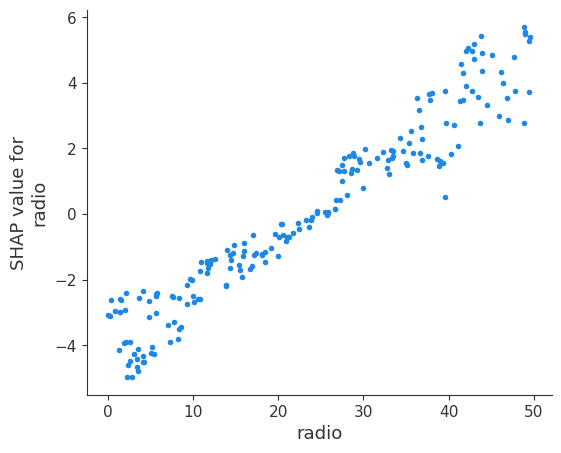

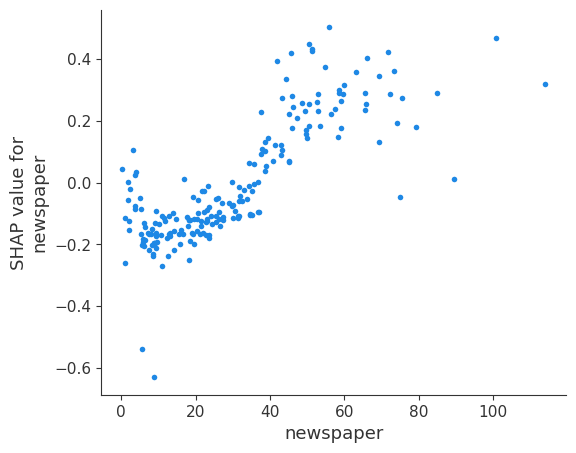

In [76]:
#각각의 Feature에 대해 shap_value 합 & 내림차순 순번 부여
top_inds = np.argsort(-np.sum(np.abs(shap_value.values), 0))

#Plot Dependence Plot
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_value.values, train, interaction_index=None)

**TV는 한계 체감**이 나타나고, 라디오는 한계 체감이 나타나지 않은 것 같네?  
광고 단가도 라디오가 훨씬 저렴한데, TV 광고를 여기서 더 집행하기보다는 라디오 광고를 더 해봐야겠다

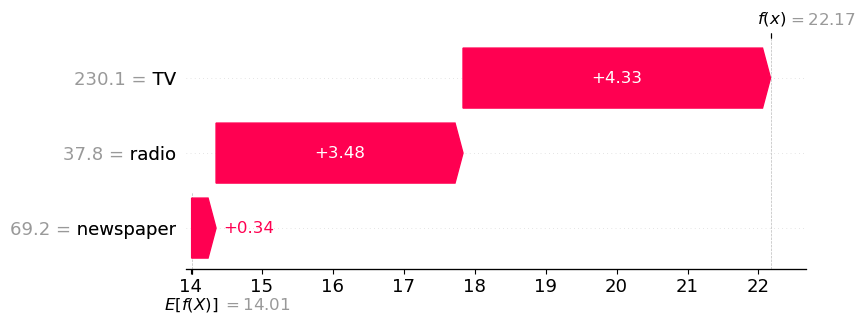

In [81]:
#참고 차트: Water Fall
shap.plots.waterfall(shap_value[0])

00일에 계산된 기댓값 22.17은 Baseline 14.01, newspaper에서 만들어진 shap value 0.34, radio에서 만들어진 shap value 3.48, tv에서 만들어진 shap value 4.33이 더해져서 계산된거구나